# Creating a Neural Network in Pyspark

In [199]:
# First, test Pyspark installation
sc

<SparkContext master=local[*] appName=PySparkShell>

## 1. First create and initialize a Spark Cluster

In [200]:
from pyspark.sql import SparkSession

In [201]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName('nn_model') \
        .config('spark.executor.memory','12gb') \
        .getOrCreate()

sc = spark.sparkContext
print('Spark Cluster Initialized Successfully!')

Spark Cluster Initialized Successfully!


In [202]:
data_link = 'https://raw.githubusercontent.com/asherif844/ApacheSparkDeepLearningCookbook/master/CH02/data/HeightAndWeight.txt'

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

print('Imported!')

Imported!


## 2. Creating a Spark DataFrame

We could create dataframes from reading .csv, .txt, .json files or even from an RDD but now we shall create the dataframe naually

In [204]:
df = spark.createDataFrame([
    ('Male', 67, 150),  # adding each row values one by one
    ('Female', 65, 135),
    ('Female', 68, 130),
    ('Male', 70, 160),
    ('Female', 70, 130),
    ('Male', 69, 174),
    ('Female', 65, 126),
    ('Male', 74, 188),
    ('Female', 60, 110),
    ('Female', 63, 125),
    ('Male', 70, 173),
    ('Male', 70, 145),
    ('Male', 68, 175),
    ('Female', 65, 123),
    ('Male', 71, 145),
    ('Male', 74, 160),
    ('Female', 64, 135),
    ('Male', 71, 175),
    ('Male', 67, 145),
    ('Female', 67, 130),
    ('Male', 70, 162),
    ('Female', 64, 107),
    ('Male', 70, 175),
    ('Female', 64, 130),
    ('Male', 66, 163),
    ('Female', 63, 137),
    ('Male', 65, 165),
    ('Female', 65, 130),
    ('Female', 64, 109)],
    ['gender', 'height', 'weight'])  # adding the column header

In [205]:
# Let's see the top 20 rows
df.show()

+------+------+------+
|gender|height|weight|
+------+------+------+
|  Male|    67|   150|
|Female|    65|   135|
|Female|    68|   130|
|  Male|    70|   160|
|Female|    70|   130|
|  Male|    69|   174|
|Female|    65|   126|
|  Male|    74|   188|
|Female|    60|   110|
|Female|    63|   125|
|  Male|    70|   173|
|  Male|    70|   145|
|  Male|    68|   175|
|Female|    65|   123|
|  Male|    71|   145|
|  Male|    74|   160|
|Female|    64|   135|
|  Male|    71|   175|
|  Male|    67|   145|
|Female|    67|   130|
+------+------+------+
only showing top 20 rows



## 3. Converting the gender values from string to integer (fem=0, mal=1)

In [206]:
from pyspark.sql import functions as f

Next, modify the gender column to a numeric value

In [207]:
df = df.withColumn('gender', f.when(df['gender']=='Female',0).otherwise(1))

df.show(3)

+------+------+------+
|gender|height|weight|
+------+------+------+
|     1|    67|   150|
|     0|    65|   135|
|     0|    68|   130|
+------+------+------+
only showing top 3 rows



Finally, reorder the columns so that gender is the last column in the dataframe

In [208]:
df = df.select('height', 'weight', 'gender')

df.show(3)

+------+------+------+
|height|weight|gender|
+------+------+------+
|    67|   150|     1|
|    65|   135|     0|
|    68|   130|     0|
+------+------+------+
only showing top 3 rows



**There's more...**

In addition to the `withColumn()` method for a dataframe, there is also the `withColumnRenamed()` method, which is used for renaming columns in a dataframe.

## 4. Converting a PySpark dataframe to an array

In order to form the building blocks of the neural network, the PySpark dataframe must be converted into an array. Python has a very powerful library, numpy, that makes working with arrays simple.

View the data collected from the dataframe...

In [209]:
df.collect()

[Row(height=67, weight=150, gender=1),
 Row(height=65, weight=135, gender=0),
 Row(height=68, weight=130, gender=0),
 Row(height=70, weight=160, gender=1),
 Row(height=70, weight=130, gender=0),
 Row(height=69, weight=174, gender=1),
 Row(height=65, weight=126, gender=0),
 Row(height=74, weight=188, gender=1),
 Row(height=60, weight=110, gender=0),
 Row(height=63, weight=125, gender=0),
 Row(height=70, weight=173, gender=1),
 Row(height=70, weight=145, gender=1),
 Row(height=68, weight=175, gender=1),
 Row(height=65, weight=123, gender=0),
 Row(height=71, weight=145, gender=1),
 Row(height=74, weight=160, gender=1),
 Row(height=64, weight=135, gender=0),
 Row(height=71, weight=175, gender=1),
 Row(height=67, weight=145, gender=1),
 Row(height=67, weight=130, gender=0),
 Row(height=70, weight=162, gender=1),
 Row(height=64, weight=107, gender=0),
 Row(height=70, weight=175, gender=1),
 Row(height=64, weight=130, gender=0),
 Row(height=66, weight=163, gender=1),
 Row(height=63, weight=13

**Store the values from the collection into an array called data_array...**

In [210]:
data_array = np.array(df.collect())
print(f'shape of data-array is {data_array.shape}')

shape of data-array is (29, 3)


In [211]:
# Let's see the first row, which is the first element in the array

data_array[0]

array([ 67, 150,   1])

**Any set of height, weight, and gender values can be accessed by referencing the index of the array. The array has a shape of (29,3) with a length of 29 elements, and each element is composed of three items. While the length is 29, the index starts at [0] and ends at [28]**

In [212]:
# Let's see the last row to ensure the numpy conversion didn't alter the order of the array

data_array[28]  # Its same as the dataframe. So it's all in order!

array([ 64, 109,   0])

**To retrieve the minimum and maximum values for height, weight, and gender...**

In [213]:
print('max per col is:',np.max(data_array, axis=0))
print('min per col is:',np.min(data_array, axis=0))

max per col is: [ 74 188   1]
min per col is: [ 60 107   0]


The maximum height is **74 inches** and minimum height is **60 inches**. The maximum weight is **188 lbs**, while the minimum weight is **107 lbs**. The minimum and maximum values for gender are not as relevant, as we have assigned them numeric values of 0 and 1 as simply categorical values with no meaningful scale to them. 

## 5. Visualizing an array in a scatterplot

The goal of the neural network that will be developed in this chapter is to predict the gender of an individual if the height and weight are known. A powerful method for understanding the relationship between height, weight, and gender is by visualizing the data points feeding the neural network. This can be done with the popular Python visualization library matplotlib.

In [214]:
import matplotlib.pyplot as plt

Next, determine the minimum and maximum values of the x and y-axes of the scatterplot using the min() and max() functions from numpy:

In [215]:
min_x = data_array.min(axis=0)[0]-10
max_x = data_array.max(axis=0)[0]+10
min_y = data_array.min(axis=0)[1]-10
max_y = data_array.max(axis=0)[1]+10

print(min_x, max_x, min_y, max_y)

50 84 97 198


Let's plot the height and weight for each gender type

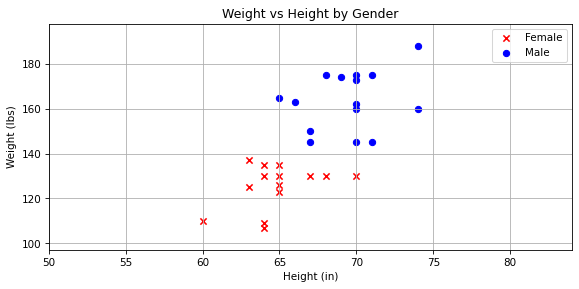

In [216]:
# formatting the plot grid, scales, and figure size

plt.figure(figsize=(9, 4), dpi= 75)
plt.axis([min_x,max_x,min_y,max_y])
plt.grid()

for i in range(len(data_array)):
    value = data_array[i]
    
    # assign labels values to specific matrix elements
    gender = value[2]
    height = value[0]
    weight = value[1]

    # filter data points by gender
    a = plt.scatter(height[gender==0],weight[gender==0], marker 
      = 'x', c= 'r', label = 'Female')
    b = plt.scatter(height[gender==1],weight[gender==1], marker 
      = 'o', c= 'b', label = 'Male')

   # plot values, title, legend, x and y axis
    plt.title('Weight vs Height by Gender')
    plt.xlabel('Height (in)')
    plt.ylabel('Weight (lbs)')
    plt.legend(handles=[a,b])

**How it Works...**

A 10-point pixel buffer has been added to each axis to ensure all data points are captured without being cut off.
A loop is created to iterate through each row of values and plot the weight versus the height.

Additionally, a different style point is assigned to the Female gender, x, and the Male gender, o.

**There's more...**

The scatterplot gives a quick and easy visual interpretation of what is going on with the data. There is an apparent divide between the upper-right quadrant and the lower-left quadrant of the scatterplot. All of the data points above 140 lbs indicate a Male gender, with all of the data points below that belong to the Female gender, as seen in the following screenshot:

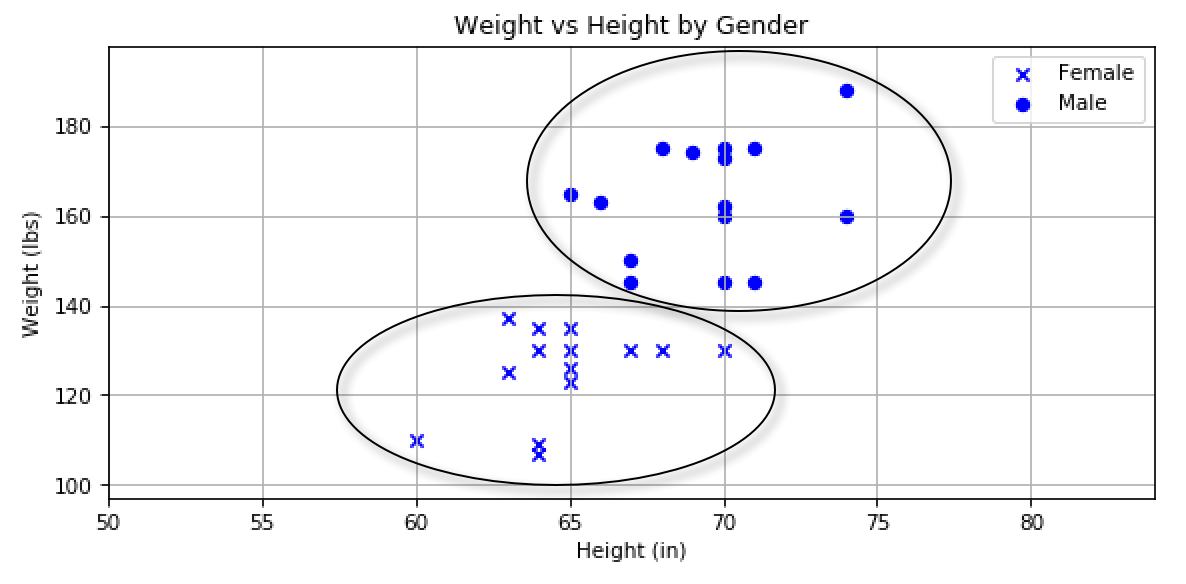

## 6. Setting up Weights and Biases

The framework in PySpark and the data are now complete. It is time to move on to building the neural network. Regardless of the complexity of the neural network, the development follows a similar path:

1. **Input data**
2. **Add the weights and biases**
3. **Sum the product of the data and weights**
4. **Apply an activation function**
5. **Evaluate the output and compare it to the desired outcome**

The Neural-Network **Summation Function** is given as 

### $z = (input1) * (w1) + (input2) * (w2) + b$

Where $input1$ in this case is the height and $input2$ the weight and $b$ is the bias-unit, while $w1$ and $w2$ are learned weights of the inputs.

In [217]:
# Set random seed for reproducibility
np.random.seed(12345)

# set weights and bias
w1 = np.random.randn()
w2 = np.random.randn()
b = np.random.randn()

print(w1, w2, b)

-0.20470765948471295 0.47894333805754824 -0.5194387150567381


For example, given inputs height=0.5 and weight=0.5, the **summation function** for our neural network will be:-

### $z = 0.5 * (-0.2047) + 0.5 * (0.47894) + (-0.51943) = -7.557$

The variable $z$ is assigned as the product summation of the weights with the data points. Currently, the weights and biases are completely random. However, as mentioned earlier in the section, through a process called backpropagation, using gradient descent, the weights will be tweaked until a more desirable outcome is determined. Gradient descent is simply the process of identifying the optimal values for our weights that will give us the best prediction output with the least amount of error.

## 7. Normalizing the input data for the neural network

* Neural networks work more efficiently when the inputs are normalized. This minimizes the magnitude of a particular input affecting the overall outcome over other potential inputs that have lower values of magnitude.
* The normalization of input values requires obtaining the mean and standard deviation of those values for the final calculation.

**First we slice the data into Features and Label...**

In [218]:
features = data_array[:,:2]
label = data_array[:,2]

print(f'features shape is {features.shape}\nlabel shape is {label.shape}')

features shape is (29, 2)
label shape is (29,)


In [219]:
# Print the min and max of each feature
min_feat = np.min(features, axis=0)
max_feat = np.max(features, axis=0)

print(f'min features: {min_feat}\nmax features: {max_feat}')

min features: [ 60 107]
max features: [ 74 188]


In [220]:
# Print the mean and std of each feature
mean_feat = np.mean(features, axis=0)
std_feat = np.std(features, axis=0)

print(f'Mean of Height and Weight: {mean_feat}\nStd of Height and Weight: {std_feat}')

Mean of Height and Weight: [ 67.20689655 145.24137931]
Std of Height and Weight: [ 3.35671545 22.1743175 ]


**Now we create a function that uses the mean and std to normalize the data**

In [221]:
def normalize(arr):
    """This method takes ID array
        and normalizes it via the
        Z-score norm.
    """
    mean_ = np.mean(arr)
    std_ = np.std(arr)
    
    arr = (arr - mean_)/std_
    
    return arr

In [222]:
features_norm = np.apply_along_axis(normalize, 0, features)

# Print the min and max of each feature
min_feat = np.min(features_norm, axis=0)
max_feat = np.max(features_norm, axis=0)

print(f'After Normalization... \nmin features: {min_feat}\nmax features: {max_feat}')

After Normalization... 
min features: [-2.14700848 -1.72457977]
max features: [2.02373527 1.92829478]


In [223]:
features_norm[:5]

array([[-0.06163661,  0.21460055],
       [-0.65745714, -0.4618577 ],
       [ 0.23627366, -0.68734378],
       [ 0.8320942 ,  0.66557271],
       [ 0.8320942 , -0.68734378]])

## 8. Validating array for optimal Neural Network performance

A little bit of validation goes a long way in ensuring that our array is normalized for optimal performance within our upcoming neural network.  

**First, let's print out the mean and std for each variable in the features-norm dataset**

In [224]:
print('standard deviation')
print(np.round(features_norm[:,:].std(axis=0),0))
print('mean')
print(np.round(features_norm[:,:].mean(axis=0),0))

standard deviation
[1. 1.]
mean
[-0.  0.]


**Next, let's column stack all the variables and the label too into the original un-normalised data-array.<br>So we're basically replacing it with the normalized version.**

In [225]:
data_array = np.column_stack((features_norm[:,0], features_norm[:,1], label))
print(data_array.shape)

(29, 3)


In [226]:
data_array[:10]

array([[-0.06163661,  0.21460055,  1.        ],
       [-0.65745714, -0.4618577 ,  0.        ],
       [ 0.23627366, -0.68734378,  0.        ],
       [ 0.8320942 ,  0.66557271,  1.        ],
       [ 0.8320942 , -0.68734378,  0.        ],
       [ 0.53418393,  1.29693375,  1.        ],
       [-0.65745714, -0.86773265,  0.        ],
       [ 2.02373527,  1.92829478,  1.        ],
       [-2.14700848, -1.58928812,  0.        ],
       [-1.25327768, -0.91282987,  0.        ]])

**Our array is now all set. Our inputs for height and weight are normalized and our output for gender is labeled as 0 or 1.**

## 9. Setting up the sigmoid activation function

An activation function is used in a neural network to help determine the output, whether it is a yes or no, true or false, or in our case 0 or 1 (male/female).  At this point, the inputs have been normalized and have been summed with the weights and bias: $w1, w2$, and $b$. However, the weights and bias are completely random at the moment and are not optimized to produce a predicted output that matches the actual output. The missing link in building the predicted outcome resides with the activation or sigmoid function, which is shown in the following diagram:

<img src='https://static.packt-cdn.com/products/9781788474221/graphics/4c941d22-accf-414a-bc9d-fa8403c770da.png' height=1000 width=800>

If the number that is produced out of the summation is very small, it will produce an activation of 0. Likewise, if the number produced out of the summation is quite large, it will produce an activation of 1. This function is useful because it restricts the output to a binary outcome, which is quite useful for classification

### There's more

The `sigmoid` function is similar to the `logistic regression function` in that it computes a probabilistic outcome between 0 and 1. Additionally, it gives a range of everything in -between. Therefore, a condition could be set to associate any value greater than 0.5 to 1 and less than 0.5 to 0.

The sigmoid function cn be denoted as

## $h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}$

In [227]:
def sigmoid(X):
    sigmoid = 1 / (1 + np.exp(-X))
    return sigmoid

**Testing the Sigmoid function**

In [228]:
X = np.arange(-10,10,1)
Y = sigmoid(X)

We have created a sample $X$ values for the sigmoid curve, and fitted it with the sigmoid function to create sample $Y$ values.
<br>Let's plot the $X$ and $Y$ curves...

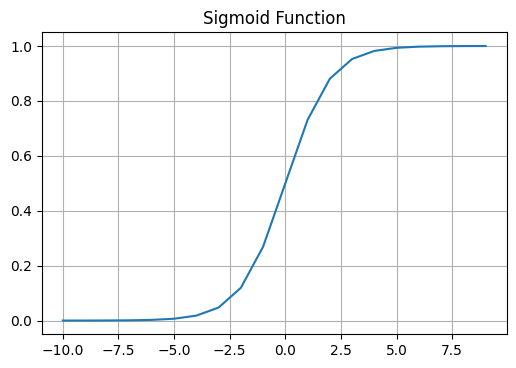

In [229]:
plt.figure(figsize=(6, 4), dpi= 100)
plt.grid()
plt.plot(X,Y)
plt.title('Sigmoid Function')
plt.show()

**Inspired by the Sigmoid function above, I have decided to do a Relu Function too...**

In [230]:
def relu(X):
    relu = [max(0, i) for i in X]
    return relu

In [231]:
X = list(range(-10, 10, 1))
Y = relu(X)

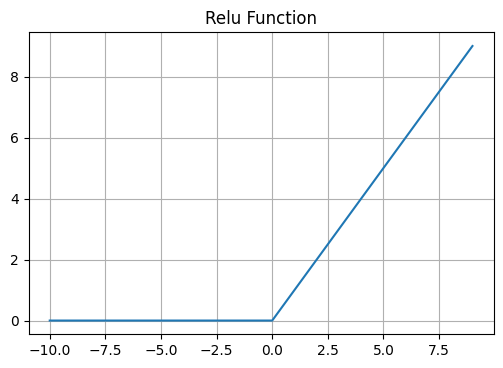

In [232]:
plt.figure(figsize=(6, 4), dpi= 100)
plt.grid()
plt.plot(X,Y)
plt.title('Relu Function')
plt.show()

### More on The Sigmoid Function...

The `sigmoid function` is a specialized version of the `logistic regression` used for classification. The calculation of the logistic regression is expressed with the following formula:

<img src='https://static.packt-cdn.com/products/9781788474221/graphics/61db350b-89e9-480e-a87f-77eb77d479f4.png' width=700>

The variables for the logistic regression function stand for the following:

* **L** stands the maximum value of the function
* **k** stands for the steepness of the curve
* **xmidpoint** stands for the midpoint value of the function

Since the `sigmoid` function has a steepness of value 1, a midpoint of 0, and a maximum value of 1, it produces the following function:

<img src='https://static.packt-cdn.com/products/9781788474221/graphics/d364b202-51d5-4f51-b338-f43e0c063992.png' width=700>

## 10. Creating the sigmoid derivative function

The sigmoid function is a unique function where the value of the derivative of the sigmoid function includes the value of the sigmoid function.  You may be asking what's the big deal.  However, since the sigmoid function is already calculated it allows for simpler and more efficient processing when performing backpropagation over many layers.  Additionally, it is the derivative of the sigmoid function that is used in the calculation to derive the optimal $w1$, $w2$, and $b$ values to derive the most accurate predicted output. 

In [233]:
def sigmoid_derivative(x):
    d = sigmoid(x) * (1-sigmoid(x))
    return d

**Let's plot the derivative of the sigmoid function alongside the original sigmoid function:**

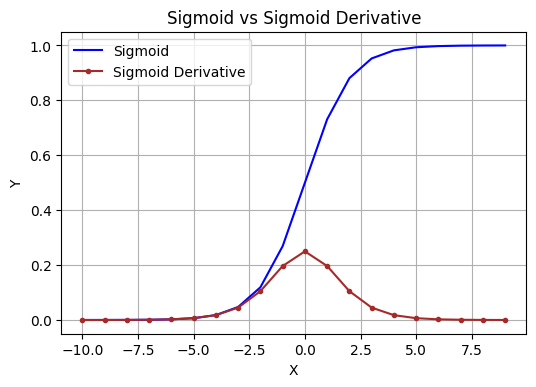

In [234]:
plt.figure(figsize=(6, 4), dpi= 100)
#plt.axis([-10,10,-0.25,1.2])
plt.grid()
X = np.arange(-10,10,1)
Y = sigmoid(X)
Y_Prime = sigmoid_derivative(X)
c=plt.plot(X, Y, label="Sigmoid",c='b')
d=plt.plot(X, Y_Prime, marker=".", label="Sigmoid Derivative", c='brown')
plt.title('Sigmoid vs Sigmoid Derivative')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

**The neural network will require the derivative of the sigmoid function to predict an accurate output for gender. The derivative of the sigmoid function is calculated using the following formula:**

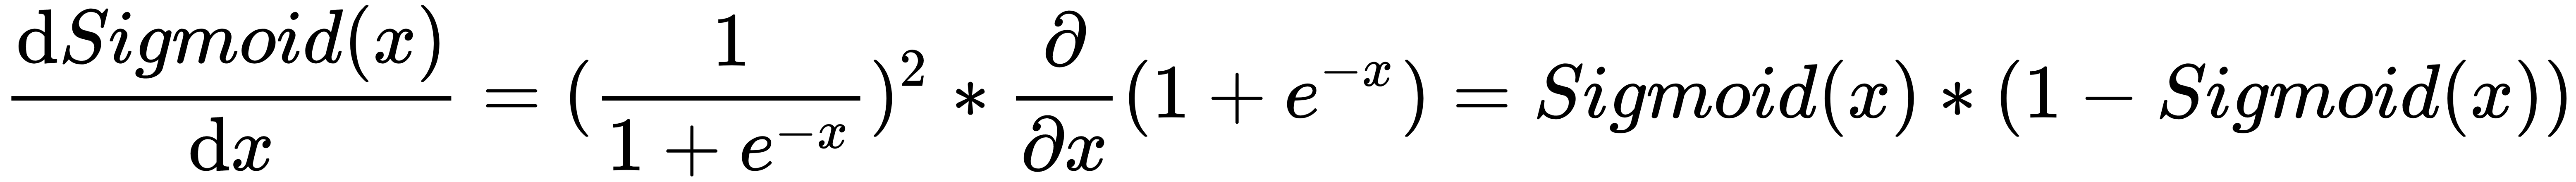

**So we can easily create the derivative of the sigmoid function, `sigmoid_derivate()`, using the original sigmoid function, `sigmoiid()`**

### There's more...

**The `Sigmoid Derivative` tracks the `slope` of the original `Sigmoid function`. Early on in the plot, when the `slope` of the Sigmoid is completely horizontal, the Sigmoid Derivative is also `0.0`.  The same holds true for Sigmoid Derivative when the value of the Sigmoid function is approaching `1` as the `slope` is also almost completely horizontal. The `peak value` of the `slope` of Sigmoid is at the `midpoint of the x-axis`. Consequently, this is also the peak value of Sigmoid Derivative.**

## 11. Calculating the cost function in a neural network

**At this point, it is time to bring together all of the parts highlighted to calculate the cost function, which will be used by the neural network to determine how well the predicted outcome matched the original or actual outcome, given the 29 individual data points that are currently available.** 

**The purpose of the cost function is to identify the difference between the actual value and the predicted value.  Gradient descent is then used to either increase or decrease the values for w1, w2, and b to decrease the value of the cost function and ultimately achieve our goal of deriving a predicted value that matches the actual value.**

**The formula for the cost function is:**

## $cost(X)=(predicted-actual)^{2}$

**The Cost function is really just another way of minimizing the squared difference between the actual output and the prediction. The purpose of gradient descent or backpropagation in a neural network is to minimize the cost function until the value is close to 0. At that point, the weights and bias ($w1, w2,$ and $b$) will no longer be random insignificant values generated by numpy, but actual significant weights contributing to a neural network model.**

Set a  learning rate value of 0.1 to incrementally change the weights and bias until a final output is selected:

In [235]:
learningRate = 0.1

Initiate a Python list called allCosts

In [236]:
all_costs = []

Next, we'd create two functions

1. partial_derivative() for computing the partial derivative scores per epoch (number of learning cycles)
2. gradient_descent() for calculating the gradient descent at the end of each epoch

In [237]:
def calc_partial_derivative(w1, w2, b, height, weight, gender):
    """This method computes the partial derivative of the
        cost function in respect to the summation function,
        iteratively for each individual in the data array.
        
    @Param w1: random (float): AKA weight 1 <weight param of current height>
    @Param w2: random (float): AKA weight 2 <weight param of current weight>
    @Param b:  random (float) representing the bias unit
    @Param height: (float) height of the current individual in data array
    @Param weight: (float) weight of the current individual in data array
    @Param gender: (float) true-gender of the current individual in data array
    @Return: (3 numbers) The derivative of the cost function in respect
             to w1, w2 and b
    """
    # This method updates the global all_costs list
    global all_costs
    
    z = w1*height + w2*weight + b
    predicted_gender = sigmoid(z)
    true_gender = gender
    cost = (predicted_gender - true_gender)**2
    all_costs.append(cost)
    
    dCost_predictedGender = 2 * (predicted_gender - true_gender)
    dPredictedGender_dz = sigmoid_derivative(z)
    dz_dw1 = height
    dz_dw2 = weight
    dz_db = 1
    
    dCost_dw1 = dCost_predictedGender * dPredictedGender_dz * dz_dw1
    dCost_dw2 = dCost_predictedGender * dPredictedGender_dz * dz_dw2
    dCost_db = dCost_predictedGender * dPredictedGender_dz * dz_db
    
    return dCost_dw1, dCost_dw2, dCost_db

In [238]:
def gradient_descent(w1, w2, b, dCost_dw1, dCost_dw2, dCost_db):
    """This function takes the current weights
        and bias as well as their computed derivatives 
        in respect to the cost function and updates 
        the weights and bias by their derivatives.
        . 
        It returns the updated weights and bias.
    """
    # This method uses the globally defined LR
    global learningRate  
    
    w1 = w1 - learningRate * dCost_dw1
    w2 = w2 - learningRate * dCost_dw2
    b = b - learningRate * dCost_db
    
    return w1, w2, b

**Next, create afor loop that runs for 100000 iterations or epochs and updates the weights and bias as it reduces the cost**

In [239]:
EPOCHS = 100000
x = EPOCHS
while EPOCHS >= 0:
    st=time.time()
    if EPOCHS % 1000 == 0:
        print(f'EPOCH: {EPOCHS}')
        print('Average Cost:',np.mean(all_costs))
    for i in range(len(data_array)):
        current_person = data_array[i]
        
        # Select the H, W, G of current person
        
        height = current_person[0]
        weight = current_person[1]
        gender = current_person[2]
        
        # Calculate partial derivatives
        
        dCost_dw1, dCost_dw2, dCost_db = calc_partial_derivative(w1, w2, b, height, weight, gender)
        
        # Update weights via Gradient descent
        
        w1, w2, b = gradient_descent(w1, w2, b, dCost_dw1, dCost_dw2, dCost_db)
    
    EPOCHS -= 1
        
print(f'Done! Full-Pass-Training for {x} epochs lasted {time.time()-st} secs!') 

EPOCH: 100000
Average Cost: nan
EPOCH: 99000
Average Cost: 0.00526237926746873
EPOCH: 98000
Average Cost: 0.003103666385422529
EPOCH: 97000
Average Cost: 0.0022533321420183734
EPOCH: 96000
Average Cost: 0.0017877827855689646
EPOCH: 95000
Average Cost: 0.0014907506731867237
EPOCH: 94000
Average Cost: 0.001283409355351337
EPOCH: 93000
Average Cost: 0.001129803931415978
EPOCH: 92000
Average Cost: 0.001011080007801597
EPOCH: 91000
Average Cost: 0.0009163531070483196
EPOCH: 90000
Average Cost: 0.0008388800315441636
EPOCH: 89000
Average Cost: 0.0007742504891956007
EPOCH: 88000
Average Cost: 0.0007194532465307425
EPOCH: 87000
Average Cost: 0.0006723591172083096
EPOCH: 86000
Average Cost: 0.0006314182425422412
EPOCH: 85000
Average Cost: 0.0005954744857513735
EPOCH: 84000
Average Cost: 0.0005636471502918172
EPOCH: 83000
Average Cost: 0.0005352530830041453
EPOCH: 82000
Average Cost: 0.0005097538992677276
EPOCH: 81000
Average Cost: 0.0004867193347252581
EPOCH: 80000
Average Cost: 0.00046580123737

**So from the above, we applied all the functions together to create a simple neural network that trained on 100000 full passes or Epochs through the entire data**<br>

**Let's plot all the costs**

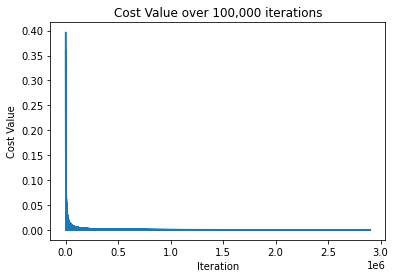

In [240]:
plt.plot(all_costs)
plt.title('Cost Value over 100,000 iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost Value')
plt.show()

**Let's see the final values of the weights and bias**

In [241]:
print('The final values of w1, w2, and b')
print('---------------------------------')
print('w1 = {}'.format(w1))
print('w2 = {}'.format(w2))
print('b = {}'.format(b))

The final values of w1, w2, and b
---------------------------------
w1 = 2.713411562847474
w2 = 16.83932304058187
b = 4.5878167190078


### 12. Make Predictions using learned weights

We can simply apply the learned weights of our model to predict the gender of the individuals in the data array as well as new unseen individuals..

In [242]:
for i in range(len(data_array)):
    random_individual = data_array[i]
    height = random_individual[0]
    weight = random_individual[1]
    z = height*w1 + weight*w2 + b
    predictedGender=sigmoid(z)
    print("Individual #{} actual score: {} predicted score:{}".format(i+1,random_individual[2],predictedGender))

Individual #1 actual score: 1.0 predicted score:0.9996759534208237
Individual #2 actual score: 0.0 predicted score:0.006871305599802431
Individual #3 actual score: 0.0 predicted score:0.0017515875198564556
Individual #4 actual score: 1.0 predicted score:0.9999999855623245
Individual #5 actual score: 0.0 predicted score:0.008759891334263912
Individual #6 actual score: 1.0 predicted score:0.999999999999218
Individual #7 actual score: 0.0 predicted score:7.443473422670033e-06
Individual #8 actual score: 1.0 predicted score:1.0
Individual #9 actual score: 0.0 predicted score:6.911379675134122e-13
Individual #10 actual score: 0.0 predicted score:6.915854387075201e-07
Individual #11 actual score: 1.0 predicted score:0.9999999999992553
Individual #12 actual score: 1.0 predicted score:0.9987234613522052
Individual #13 actual score: 1.0 predicted score:0.9999999999991787
Individual #14 actual score: 0.0 predicted score:7.627114339574482e-07
Individual #15 actual score: 1.0 predicted score:0.999

**Just merely looking at the predictions, I can say the model did a pretty good job. We can evaluate the models performance via any evaluationmetric like Accuracy or Recall or F1 score.<br>While this is good for confirming the model produced matching results on the training data, ultimately, the test will be to determine whether the model can make accurate gender predictions on new individuals introduced to it.**

### 13. Predicting gender based on height and weight

A predictive model is only useful if it can actually predict based on new information. This is the case with a simple logistic or linear regression, or a more complex neural network model.

First we create a function called input-normalize that normalizes any given input for height and weight just the way we normalized values in data_array.

In [243]:
def input_normalize(height, weight):
    height_mean, weight_mean = mean_feat[0], mean_feat[1]
    height_std, weight_std = std_feat[0], std_feat[1]
    
    height = (height - height_mean) / height_std
    weight = (weight - weight_mean) / weight_std
    
    return height, weight

Next, we define a predict method that takes the new height and weight and calls input-normalize method too. And finally predicts Male or Female

In [244]:
def predict_gender(height, weight):
    height, weight = input_normalize(height, weight)
    
    # computing the summation function
    gender_summation = w1*height + w2*weight + b
    
    # Applying the sigmoid function
    gender_summation = sigmoid(gender_summation)
    
    # Based on the output and a threshold of 0.5
    # Values from 0 to 0.5: Female and above 0.5 Male
    
    if gender_summation <= 0.5:
        return 'Female', np.round(gender_summation, 6)
    else:
        return 'Male', np.round(gender_summation, 6)

In [245]:
height = [70, 50, 64, 71]
weight = [180, 120, 135, 175]

for h, w in zip(height, weight):
    print(f'Height:{h}, Weight:{w}...')
    print(predict_gender(h, w))
    print()

Height:70, Weight:180...
('Male', 1.0)

Height:50, Weight:120...
('Female', 0.0)

Height:64, Weight:135...
('Female', 0.003074)

Height:71, Weight:175...
('Male', 1.0)



### 14. Visualizing Prediction Scores

This section walks through the steps to visualize all of the predicted points in a graph.

In [246]:
x_min = min(data_array[:,0])-0.1
x_max = max(data_array[:,0])+0.1
y_min = min(data_array[:,1])-0.1
y_max = max(data_array[:,1])+0.1
increment= 0.05

print(x_min, x_max, y_min, y_max)

-2.2470084815874505 2.123735267333623 -1.8245797669033634 2.028294779946051


Generate x and y values in increments of 0.05 units and then create an array called xy_data, as seen in the following script:

In [247]:
x_data= np.arange(x_min, x_max, increment)
y_data= np.arange(y_min, y_max, increment)
xy_data = [[x_all, y_all] for x_all in x_data for y_all in y_data]

In [248]:
xy_data[0:5]

[[-2.2470084815874505, -1.8245797669033634],
 [-2.2470084815874505, -1.7745797669033634],
 [-2.2470084815874505, -1.7245797669033633],
 [-2.2470084815874505, -1.6745797669033633],
 [-2.2470084815874505, -1.6245797669033633]]

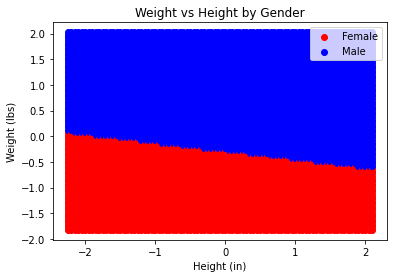

In [249]:
for i in range(len(xy_data)):
    data = (xy_data[i])
    height = data[0]
    weight = data[1] 
    z_new = height*w1 + weight*w2 + b
    predictedGender_new=sigmoid(z_new)
    # print(height, weight, predictedGender_new)
    ax = plt.scatter(height[predictedGender_new<=0.5],
            weight[predictedGender_new<=0.5],     
            marker = 'o', c= 'r', label = 'Female')    
    bx = plt.scatter(height[predictedGender_new > 0.5],
            weight[predictedGender_new>0.5], 
            marker = 'o', c= 'b', label = 'Male') 
    # plot values, title, legend, x and y axis
    plt.title('Weight vs Height by Gender')
    plt.xlabel('Height (in)')
    plt.ylabel('Weight (lbs)')
    plt.legend(handles=[ax,bx])

In [250]:
if False:
    spark.stop()
    print('Session Stopped!')